In [111]:
import datetime as dt
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
from matplotlib import pyplot as plt
from PyAstronomy import pyasl
from scipy.signal import find_peaks
import seaborn as sns
from scipy.stats import norm
import xlsxwriter
from scipy import stats 

In [112]:
dataT = pd.read_csv('Tech.csv')
dataI = pd.read_csv('Iodine.csv')

In [113]:
xt = dataT['Date']
xi = dataI['Date']

In [114]:
# Converts our date time sequence into an integer
def change_date_to_int(x):
    year = []
    for i in range(len(x)):
        a = x[i].split('/')
        b = a[2].split(' ')
        c = b[1].split(':')
        d = dt.datetime(int(b[0])-11,int(a[1]),int(a[0]), int(c[0]), int(c[0]))
        b = pyasl.decimalYear(d)
        year.append(b)
    year = np.array(year)-year[0]
    return year*365 # Returns time in days

# Finds the relative difference or the residual of an array
def rel_dif(x):
    x = x.values
    a = np.mean(x)
    d = x - a
    return d

# Detection of peaks
def peak(power):
    from scipy.signal import argrelextrema
    # for local maxima
    a = argrelextrema(power, np.greater)
    # for local minima
    b = argrelextrema(power, np.less)
    return a, b

def results_to_xlsx(power, frequency):
    workbook = xlsxwriter.Workbook('Iodine_Fap1.xlsx') 
    worksheet = workbook.add_worksheet()
    a, b = peak(power)
    # Creating the column names
    worksheet.write('A1', 'Power') 
    worksheet.write('B1', 'Frequency') 
    worksheet.write('C1', 'FAP : baluev') 
    worksheet.write('D1', 'FAP : davies') 
    worksheet.write('E1', 'FAP : naive') 
    worksheet.write('F1', 'FAP : bootstrap') 


    row = 1
    col = 0
    count = 0
    sig = []
    for i in range(len(a[0])): 
        worksheet.write(row, col, power[a[0][i]]) 
        worksheet.write(row, col + 1, frequency[a[0][i]]) 

        worksheet.write(row, col + 2, ls.false_alarm_probability(power[a[0][i]], method='baluev'))
        worksheet.write(row, col + 3, ls.false_alarm_probability(power[a[0][i]], method='davies'))
        worksheet.write(row, col + 4, ls.false_alarm_probability(power[a[0][i]], method='naive'))
        worksheet.write(row, col + 5, ls.false_alarm_probability(power[a[0][i]], method='bootstrap'))

        row += 1

    workbook.close()

In [115]:
dataT['Date'] = dataT['Date']-dataT['Date'][0]
dataI['Date'] = change_date_to_int(xi)

In [116]:
print('Mean of Tc is ', np.mean(dataT['T 1/2']), '(hrs) and standard deviation is ', np.std(dataT['T 1/2']))
print('Mean of I is ', np.mean(dataI['T 1/2']), '(hrs) and standard deviation is ', np.std(dataI['T 1/2']))

Mean of Tc is  6.012450683387166 (hrs) and standard deviation is  0.00672881620776358
Mean of I is  13.249155030556063 (hrs) and standard deviation is  0.03102783710304756


In [117]:
meantc = np.mean(dataT['T 1/2'])
stdtcp = np.mean(dataT['T 1/2'])+np.std(dataT['T 1/2'])
stdtcn = np.mean(dataT['T 1/2'])-np.std(dataT['T 1/2'])

meani = np.mean(dataI['T 1/2'])
stdip = np.mean(dataI['T 1/2'])+np.std(dataI['T 1/2'])
stdin = np.mean(dataI['T 1/2'])-np.std(dataI['T 1/2'])

In [118]:
Li = np.array(dataI['Lower bar'])
Ui= np.array(dataI['Upper bar'])
yerri = []
for i in range(len(Li)):
    yerri.append((Li[i], Ui[i]))
yerri = np.array(yerri).T

Lt = np.array(dataT['Lower bar'])
Ut= np.array(dataT['Upper bar'])
yerrt = []
for i in range(len(Lt)):
    yerrt.append((Lt[i], Ut[i]))
yerrt = np.array(yerrt).T

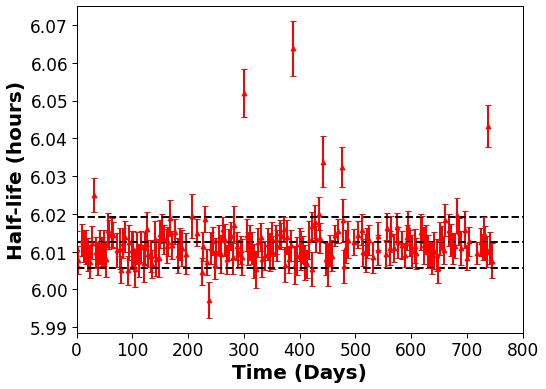

In [119]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(dataT['Date'], dataT['T 1/2'], yerrt , fmt='r^', ecolor = 'red', elinewidth = 2.0, capsize = 3,  markeredgecolor='red',markerfacecolor='red', label = 'Tc')
plt.tick_params(labelsize=17)
plt.hlines(meantc, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.hlines(stdtcp, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.hlines(stdtcn, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.xlim(0, 800)
plt.ylabel('Half-life (hours)', fontsize = 20,weight='bold')
# plt.legend(fontsize=16)
plt.xlabel('Time (Days)', fontsize=20,weight='bold')
plt.savefig('HalfLifeTech.pdf', bbox_inches='tight', dpi = 300)
# plt.show()

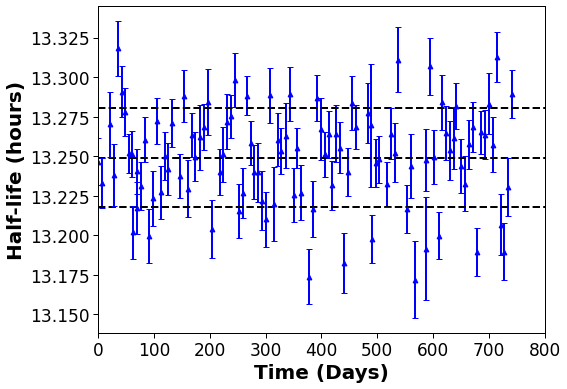

In [120]:
# fig, ax = plt.subplots(2, sharex='col', figsize = (12, 12))

fig = plt.figure(figsize = (8, 6))
plt.errorbar(dataI['Date'], dataI['T 1/2'], yerri , fmt='r^', ecolor = 'blue', elinewidth = 2.0, capsize = 3,  markeredgecolor='blue',markerfacecolor='blue', label = 'I')
plt.tick_params(labelsize=17)
plt.hlines(meani, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.hlines(stdip, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.hlines(stdin, 0, 800, colors='k', linestyles='dashed',linewidth=2.0)
plt.xlim(0, 800)
plt.ylabel('Half-life (hours)', fontsize = 20,weight='bold')
# plt.legend(fontsize=16, loc='upper right')
plt.xlabel('Time (Days)', fontsize=20,weight='bold')
plt.savefig('HalfLifeIod.pdf', bbox_inches='tight', dpi = 300)

In [121]:
#  Delta is mean of upper bar and lower bar
dyt = (Lt+Ut)/2
dyi = (Li+Ui)/2 

In [122]:
#Applying LombScargle Periodogram to our data

lst = LombScargle(dataT['Date'], dataT['T 1/2'], dyt)
frequencyt, powert = lst.autopower(nyquist_factor=5, samples_per_peak=5)

lsi = LombScargle(dataI['Date'], dataI['T 1/2'], dyi)
frequencyi, poweri = lsi.autopower(nyquist_factor=5, samples_per_peak=5)

In [123]:
a, b, c = np.max(frequencyi), np.min(frequencyi), len(frequencyi)
d, e, f = np.max(frequencyt), np.min(frequencyt), len(frequencyt)

#### Freq. Resolution of I, Tc respectively

In [124]:
print('Frequency resolution of Iodine is ', 1/(5*(np.max(dataI['Date']))), (d-e)/f)

Frequency resolution of Iodine is  0.0002696341401760486 0.0002682901478409455


In [125]:
print('Frequency resolution of Technetium is ',1/(5*(np.max(dataT['Date']))), (a-b)/c)

Frequency resolution of Technetium is  0.00026840559110593724 0.000269420653129195


#### Max Frequencies of I, Tc respectively

In [126]:
print('Max. Frequency of Iodine is ',5/(2*np.mean(np.diff(dataI['Date']))), a)

Max. Frequency of Iodine is  0.33704267522006076 0.3404131019722613


In [127]:
print('Max. Frequency of Technetium is ',5/(2*np.mean(np.diff(dataT['Date']))), d)


Max. Frequency of Technetium is  0.62068792943248 0.6239087965257513


In [128]:
xmint = 1/(np.max(dataT['Date']))
xmaxt = np.max(frequencyt)
ymint = np.min(powert)
ymaxt = np.max(powert)

xmini = 1/(np.max(dataI['Date']))
xmaxi = np.max(frequencyi)
ymini = np.min(poweri)
ymaxi = np.max(poweri)

In [129]:
m = 0
for i in powert:
    if i == np.max(powert):
        print('Maximum power from the LS periodograms for Tc appears at a period of ', 1/(np.array(frequencyt)[m]), ' days')
        break
    else:
        m = m+1
        
m = 0
for i in poweri:
    if i == np.max(poweri):
        print('Maximum power from the LS periodograms for I appears at a period of ', 1/(np.array(frequencyi)[m]), ' days')
        break
    else:
        m = m+1

Maximum power from the LS periodograms for Tc appears at a period of  11.071931064607767  days
Maximum power from the LS periodograms for I appears at a period of  23.3989221871714  days


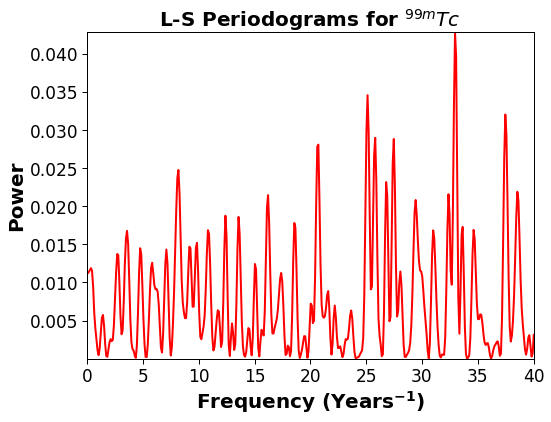

In [130]:
#plotting power vs frequency 
fig = plt.figure(figsize = (8, 6))
plt.xlim(0,40)
plt.ylim(ymint,ymaxt)
sns.set_context("paper")
plt.plot(365*frequencyt, powert, color = 'red', linewidth = 2, label = 'Technetium') 

plt.title(r'L-S Periodograms for ${}^{99m}Tc$', fontsize=20, weight = 'bold')
plt.xlabel(r'Frequency ($\mathbf{Years^{-1}}$)',fontsize=20,weight='bold')
plt.ylabel('Power', fontsize=20, weight='bold')
plt.tick_params(labelsize=17)
# plt.legend()
# plt.savefig('LSTech_tech_red.pdf', bbox_inches='tight', dpi = 300)

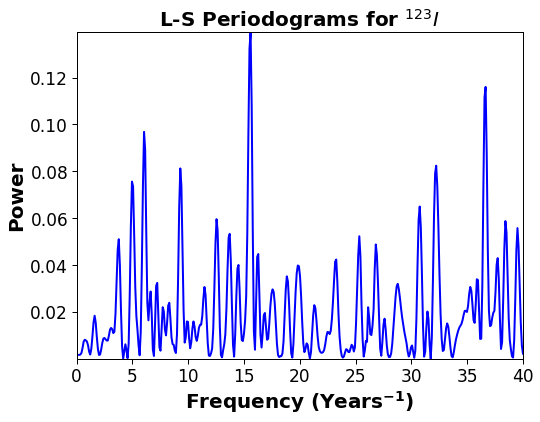

In [131]:
#plotting power vs frequency
fig = plt.figure(figsize = (8, 6))
plt.xlim(0,40)
plt.ylim(ymini, ymaxi)
plt.plot(365*frequencyi, poweri, color = 'blue', linewidth = 2) 

plt.title(r'L-S Periodograms for ${}^{123}I$', fontsize=20, weight = 'bold')
plt.xlabel(r'Frequency ($\mathbf{Years^{-1}}$)',fontsize=20,weight='bold')
plt.ylabel('Power', fontsize=20, weight='bold')
plt.tick_params(labelsize=17)
# plt.legend()
# plt.savefig('LSIod_iod_blue.pdf', bbox_inches='tight', dpi = 300)

In [132]:
dt = pd.DataFrame(data = powert, columns = ['power'])
dt['frequency'] = frequencyt
dt['period'] = 1/frequencyt
dt['FAP : Baluev'] =  lst.false_alarm_probability(powert, method='baluev')
dt['FAP : Bootstrap'] =  lst.false_alarm_probability(powert, method='bootstrap')
dt['FAP : Davies'] = lst.false_alarm_probability(powert, method='davies')
dt['FAP : Naive'] = lst.false_alarm_probability(powert, method='naive')

In [133]:
dt.to_csv('Technetium_FAP.csv', index = False)

In [134]:
di = pd.DataFrame(data = poweri, columns = ['power'])
di['frequency'] = frequencyi
di['period'] = 1/frequencyi
di['FAP : Baluev'] =  lsi.false_alarm_probability(poweri, method='baluev')
di['FAP : Bootstrap'] =  lsi.false_alarm_probability(poweri, method='bootstrap')
di['FAP : Davies'] = lsi.false_alarm_probability(poweri, method='davies')
di['FAP : Naive'] = lsi.false_alarm_probability(poweri, method='naive')

In [135]:
di.to_csv('Iodine_FAP.csv', index = False)

In [136]:
def pow_min(a, t, thresh):
    return (a[abs(a['period']-t)<thresh])

In [137]:
pow_min(dt, 365,  15)

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
10,0.000457,0.002818,354.829029,1.0,1.0,95.188037,1.0


In [138]:
pow_min(dt, 28.3,  0.05)

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
131,0.002645,0.035295,28.332356,1.0,1.0,186.546815,1.0


In [139]:
pow_min(di, 365, 15)

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
10,0.005691,0.002831,353.212302,1.0,1.0,107.570364,1.0


In [140]:
pow_min(di, 28.3, 0.1)

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
131,0.001579,0.035457,28.203264,1.0,1.0,69.6544,1.0


In [141]:
pt_28 = 0.002645
pt_365 = 0.000457 
p365i = 0.005691
p28i = 0.001579

#### Checking for maximum power within the solar rotation limit ( 8-14 per year - at 26, 46, days)

In [142]:
a, b = 26.071428571428573, 45.625
dta = dt[dt['period']>a].copy()
dtt = dta[dta['period']<b].copy()
dtt[dtt['power']>0.024]

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
83,0.024744,0.022412,44.619219,1.0,1.0,74.05312,1.0


In [143]:
a, b = 26.071428571428573, 45.625
dia = di[di['period']>a].copy()
dii = dia[dia['period']<b].copy()
dii[dii['power']>0.080]

,power,frequency,period,FAP : Baluev,FAP : Bootstrap,FAP : Davies,FAP : Naive
94,0.081221,0.02548,39.245811,0.999843,1.0,8.761869,0.98185


In [144]:
pt_28 = 0.002645
pt_365 = 0.000457 
p365i = 0.005691
p28i = 0.001579

### For Technetium

#### The following is observed for Tc

In [145]:
fbt_365 = lst.false_alarm_probability(pt_365, method = 'baluev')
fnt_365 = lst.false_alarm_probability(pt_365, method = 'naive')
fdt_365 = lst.false_alarm_probability(pt_365, method = 'davies')
fboott_365 = lst.false_alarm_probability(pt_365, method = 'bootstrap')

In [146]:
print(fbt_365, fnt_365, fdt_365, fboott_365)

1.0 1.0 95.21258899656962 1.0


In [147]:
fbt_28 = lst.false_alarm_probability(pt_28, method = 'baluev')
fnt_28 = lst.false_alarm_probability(pt_28, method = 'naive')
fdt_28 = lst.false_alarm_probability(pt_28, method = 'davies')
fboott_28 = lst.false_alarm_probability(pt_28, method = 'bootstrap')

In [148]:
print(fbt_28, fnt_28, fdt_28, fboott_28)

1.0 1.0 186.54239253917495 1.0


#### FAP at max power for Tc (11.07 days)

In [149]:
ptmax = np.max(powert)
fbt_m = lst.false_alarm_probability(ptmax, method = 'baluev')
fnt_m = lst.false_alarm_probability(ptmax, method = 'naive')
fdt_m = lst.false_alarm_probability(ptmax, method = 'davies')
fboott_m = lst.false_alarm_probability(ptmax, method = 'bootstrap')

In [150]:
print(fbt_m, fnt_m, fdt_m, fboott_m)

0.9999999812898678 0.9998127092632447 17.79403125463213 0.925


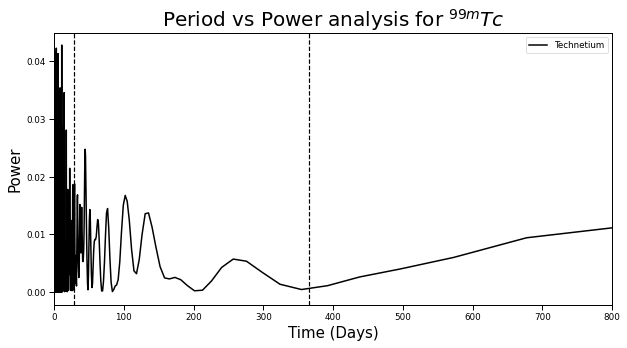

In [160]:
fig = plt.figure(figsize = (10, 5))
plt.plot(dt['period'], dt['power'], color = 'black', linewidth = 1.5, label = 'Technetium')
plt.axvline(x=365, linestyle = '--', color = 'black')
plt.axvline(x=28.3, linestyle = '--', color = 'black')
plt.title(r'Period vs Power analysis for ${}^{99m}Tc$', fontsize = 20)
plt.xlabel('Time (Days)', fontsize = 15)
plt.ylabel('Power', fontsize = 15)

plt.xlim(0, 800)
plt.legend()
plt.savefig('Tech_Per_Pow_black.pdf')

 ### For Iodine

#### The following is observed for I

In [152]:
baluev365i =  lsi.false_alarm_probability(p365i, method='baluev')
bootstrap365i =  lsi.false_alarm_probability(p365i, method='bootstrap')
davies365i = lsi.false_alarm_probability(p365i, method='davies')
naive365i = lsi.false_alarm_probability(p365i, method='naive')

In [153]:
print(baluev365i, bootstrap365i, davies365i, naive365i)

1.0 1.0 107.57018707597678 1.0


In [154]:
baluev28i =  lsi.false_alarm_probability(p28i, method='baluev')
bootstrap28i =  lsi.false_alarm_probability(p28i, method='bootstrap')
davies28i = lsi.false_alarm_probability(p28i, method='davies')
naive28i = lsi.false_alarm_probability(p28i, method='naive')

In [155]:
print(baluev28i, bootstrap28i, davies28i, naive28i)

1.0 1.0 69.65667879561174 1.0


#### FAP at max power for I (23.39 days)

In [156]:
pimax = np.max(poweri)
fbi_m = lsi.false_alarm_probability(pimax, method = 'baluev')
fni_m = lsi.false_alarm_probability(pimax, method = 'naive')
fdi_m = lsi.false_alarm_probability(pimax, method = 'davies')
fbooti_m = lsi.false_alarm_probability(pimax, method = 'bootstrap')

In [157]:
print(fbi_m, fni_m, fdi_m, fbooti_m)

0.3832016351639076 0.14976544778062933 0.4832129013916022 0.266


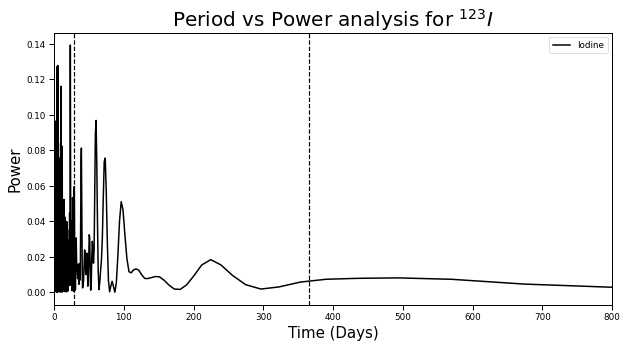

In [159]:
fig = plt.figure(figsize = (10, 5))
plt.plot(di['period'], di['power'], color = 'black', linewidth = 1.5, label = 'Iodine')
plt.axvline(x=365, linestyle = '--', color = 'black')
plt.axvline(x=28.3, linestyle = '--', color = 'black')
plt.title(r'Period vs Power analysis for ${}^{123}I$', fontsize = 20)
plt.xlabel('Time (Days)', fontsize = 15)
plt.ylabel('Power', fontsize = 15)
plt.xlim(0, 800)
plt.legend()
plt.savefig('Iod_Per_Pow_black.pdf')